# Project of image analysis --- Handwriting recognition

## Import packages and load data

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
from pytesseract import image_to_string
import os
os.sys.path
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
import numpy as np
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,645 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
carpenter_path = '/content/drive/MyDrive/Project of Image Analysis/image/carpenter.jpg'
test_path = '/content/drive/MyDrive/Project of Image Analysis/testimages/test6.jpg'
image = cv2.imread(carpenter_path)
test_image = cv2.imread(test_path)
image = cv2.resize(image, (1470,365),interpolation = cv2.INTER_AREA)
t_image = cv2.resize(test_image, (1470,365),interpolation = cv2.INTER_AREA)

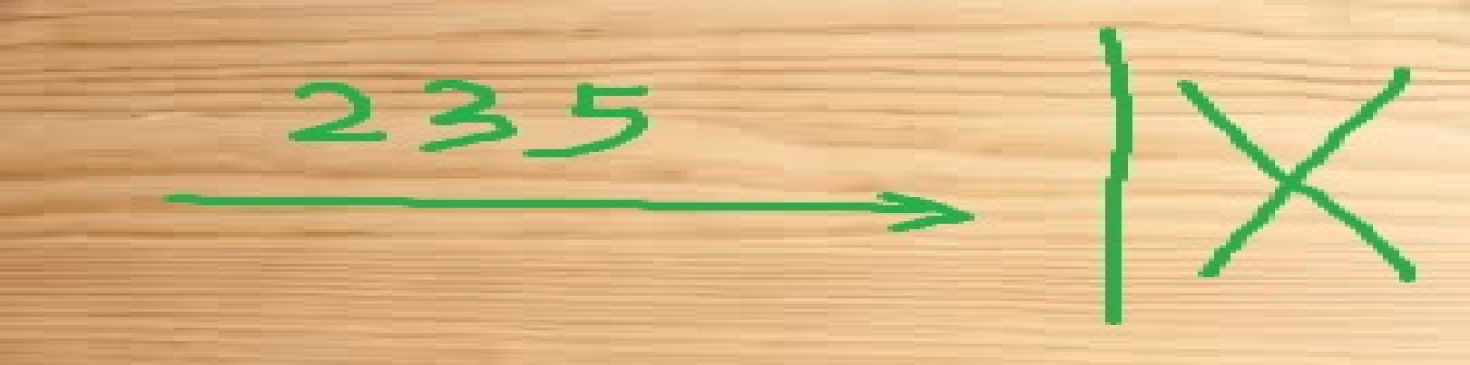

In [ ]:
cv2_imshow(t_image)

## Functions

In [ ]:

def preprocessing(img):  # using color detection get the all the symbols
    #HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of green color in HSV
    lower_green = np.array([25,20,0]) # for test6
    upper_green = np.array([100,200,250])
    # lower_green = np.array([20,45,0]) # for test3
    # upper_green = np.array([90,250,250]) 

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)   
    res = cv2.medianBlur(res,15)
    # cv2_imshow(imgMedianBlur)
    return res


def finding_Contours(image):
    #blur
    median_blur = cv2.medianBlur(image,3)
     
    #cv2_imshow(median_blur)

    #find edges with Canny
    edge = cv2.Canny(median_blur,100,170)
    # cv2_imshow(edge)

    #find and sort contours
    contours, h = cv2.findContours(edge, 
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    return contours[:10]


def draw_contours(image):  
    # Iterate over the output "lines" and draw lines on the blank   
    # Draw all contours 
    # -1 signifies drawing all contours 
    image_contours = cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
    
    print("Number of contours = " + str(len(contours)))
    return  image_contours


def centroid(cnt):
    moment = cv2.moments(cnt)
    x = int(moment ["m10"] / moment["m00"])
    y = int(moment ["m01"] / moment["m00"])
    cv2.circle(img, (X, Y), 15, (205, 114, 101), 1)
    return x,y


def single_out_symbols(image):  #??? how to get the digits completely?
  height, width = image.shape[:2]
  black = np.zeros((height,width,3), dtype = "uint8")
  contours = finding_Contours(image)
  imgs = []
  for i in range(0, len(contours)):
    img = black.copy()
    cnt = contours[i]
    cv2.drawContours(img, cnt, -1, (255,255,255), thickness = 3) 
    cv2.fillPoly(img, pts =[cnt], color=(255,255,255))
    # cv2_imshow(img)
    # cv2.imwrite('cnt'+ str(i)+'.jpg',img)
    imgs.append(img)
  return imgs[:10]


In [ ]:
#get the coordinates of symbols in order to cut the corresponding  symbol from original image
def bounding_coordinates(img,original_img): 
  image = resize(original_img)
  contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  x,y,w,h = 0,0,0,0
  for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
  imgCropped = image[y:y+h,x:x+w]
  return imgCropped

#load dataset images
def load_imgs(path):
  onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
  images = np.empty(len(onlyfiles), dtype=object)
  for n in range(0, len(onlyfiles)):
    images[n] = cv2.imread( join(path,onlyfiles[n]) )
  return images


def rotation(img,degree):  # rotate 180 degree
  (h, w) = img.shape[:2] 
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, degree, 1.0) 
  rotated = cv2.warpAffine(img, M, (w, h))
  return rotated



def input_standardization(imgs):
  standard_imgs = imgs[0][np.newaxis,:]
  for i in range(1,len(imgs)):
    A = imgs[i][np.newaxis,:]
    standard_imgs = np.vstack((standard_imgs,A))
  return standard_imgs

def standard_background(image):
  
  def resize(img):
    width, height = 400, 100
    resized = cv2.resize(img, (width,height),interpolation = cv2.INTER_AREA)
    image = resized.reshape(height, width, 1)
    return image

  height, width = image.shape[:2]
  black = np.zeros((365,1470,1), dtype = "uint8")
  x = int((1470 - width)/2)
  y = int((365 - height)/2)
  x2 = int((1470 + width)/2)
  y2 = int((365 + height)/2)
  image = image.reshape(height,width,1)
  black[y:y2, x:x2] = image
  img = resize(black)
  return img

def preprocessing_symbols(img):
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #HSV
  lower_black = np.array([0,0,0])
  upper_black = np.array([200,100,125])
  
  # Threshold the HSV image to get only blue colors
  mask = cv2.inRange(hsv, lower_black, upper_black)

  # Bitwise-AND mask and original image
  res = cv2.bitwise_and(img,img, mask= mask)
  
  #tresholding
  kernel = np.ones((5,5),np.uint8)
  gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

  ret,thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
  dilation = cv2.dilate(thresh1,kernel,iterations = 1)
  image = standard_background(dilation)

  # return dilation
  return image

# input original image and transfer it to image of single symbols
def split_symbols(img): 
  image = preprocessing(img) # color detection
  image = cv2.resize(image, (1470,365),interpolation = cv2.INTER_AREA)
  height, width = image.shape[:2]
  black = np.zeros((height,width,1), dtype = "uint8")
  contours = finding_Contours(image)
  # cv2_imshow(image)
  positions = []
  imgs = []
  for i in range(0, len(contours)):
    img = black.copy()
    cnt = contours[i]
    cv2.drawContours(img, cnt, -1, (255,255,255), thickness = 3) 
    cv2.fillPoly(img, pts =[cnt], color=(255,255,255))
    # cv2_imshow(img)
    x,y,w,h = cv2.boundingRect(cnt)
    positions.append([x,y,w,h])
    imgCropped = img[y:y+h,x:x+w]
    img = standard_background(imgCropped)
    imgs.append(img)
  return input_standardization(imgs), np.array(positions)

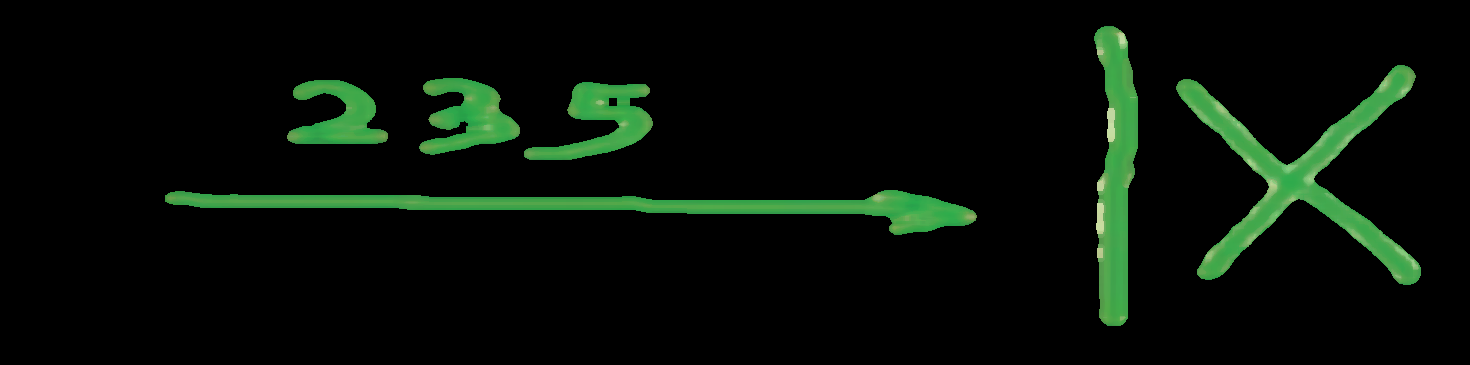

In [ ]:
# test
a = preprocessing(t_image)
cv2_imshow(a)
# # #finding_Contours(a)
# imgs = single_out_symbols(a)
# for img in imgs:
#   cv2_imshow(img)

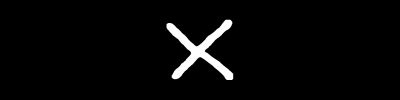

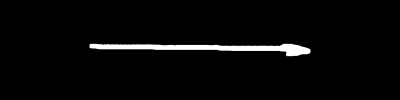

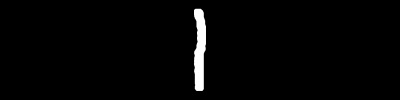

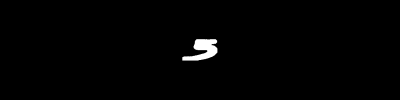

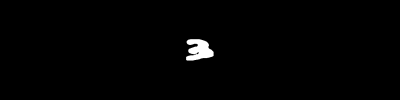

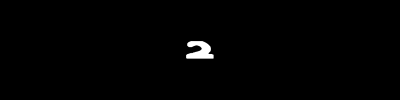

In [ ]:
# test
# imgs = single_out_symbols(t_image)
imgs, positions = split_symbols(t_image)
for i in range(0,len(imgs)):
  cv2_imshow(imgs[i])

## part 2. Detected three symbols : dimension line, cut line and X symbol

### step 2.1 Prepare datasets

In [ ]:
image_path = '/content/drive/MyDrive/Project of Image Analysis/image/carpenter.jpg'
img=cv2.imread(image_path)

In [ ]:
image_x_path = '/content/drive/MyDrive/Project of Image Analysis/X'
image_arrow_path = '/content/drive/MyDrive/Project of Image Analysis/Arrow'
image_verticalLine_path = '/content/drive/MyDrive/Project of Image Analysis/Vertical line'

In [ ]:
images_X = load_imgs(image_x_path)
images_arrow = load_imgs(image_arrow_path)
images_vline = load_imgs(image_verticalLine_path)

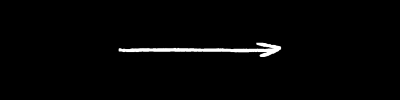

(100, 400, 1)
(3,)
(3, 100, 400, 1)


(3, 100, 400, 1)

In [ ]:
# test
image_x_path = '/content/drive/MyDrive/Project of Image Analysis/symbols 4 training/x_crop.png'
image_arrow_path = '/content/drive/MyDrive/Project of Image Analysis/symbols 4 training/arrow_crop.png'
image_verticalLine_path = '/content/drive/MyDrive/Project of Image Analysis/symbols 4 training/cutline_crop.png'

images_X = cv2.imread(image_x_path)[:,:,0].reshape(100,400,1)
images_arrow = cv2.imread(image_arrow_path)[:,:,0].reshape(100,400,1)
images_vline = cv2.imread(image_verticalLine_path)[:,:,0].reshape(100,400,1)
cv2_imshow(images_arrow)
print(images_X.shape)
n = 3
X = np.empty(n, dtype = object)
y = np.empty(n,dtype = int)
for i in range(0,n):
  if i< 1:
    X[i] = images_X
    y[i] = 0
  elif i< 2:
    X[i] = images_arrow
    y[i] = 1
  elif i< 3:
    X[i] = images_vline
    y[i] = 2
print(X.shape)
X_new = X[0][np.newaxis,:]
for i in range(1,len(X)):
  A = X[i][np.newaxis,:]
  X_new = np.vstack((X_new,A))
print(X_new.shape)
X_new.shape


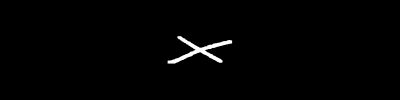

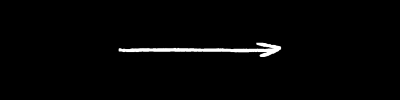

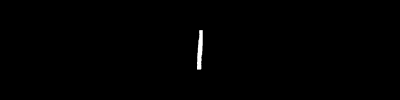

In [ ]:
for x in X_new:
  cv2_imshow(x)

In [ ]:
# test
cnn_model.fit(X_new,y, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 189ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 196ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 195ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 198ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 197ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 204ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 189ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 211ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 193ms/step - loss: 1.2716e-06 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 192ms/step - loss:

In [ ]:
# extend images of arrow by rotation
n = len(images_arrow)
images_arrow_extend = np.empty(2*n, dtype=object)
for i in range(0,n):
  rotated = rotation(images_arrow[i],180) # rotate 180 degree
  images_arrow_extend[i] = images_arrow[i]
  images_arrow_extend[n+i] = rotated

# extend images of vertical line
n = len(images_vline)
images_vline_extend = np.empty(2*n, dtype = object)
for i in range(0,n):
  rotated = rotation(images_vline[i],90) # rotate 90 degree
  images_vline_extend[i] = images_vline[i]
  images_vline_extend[n+i] = rotated 

# extend images of X
n = len(images_X)
images_X_extend = np.empty(2*n, dtype = object)
for i in range(0,n):
  rotated = rotation(images_X[i],90) # rotate 90 degree
  images_X_extend[i] = images_X[i]
  images_X_extend[n+i] = rotated

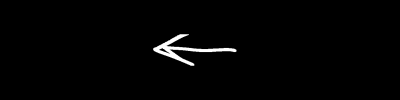

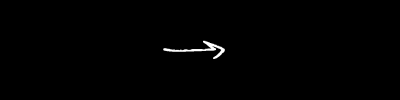

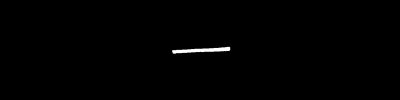

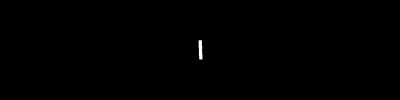

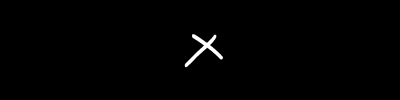

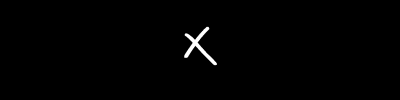

In [ ]:
# test
cv2_imshow(preprocessing_symbols(images_arrow_extend[len(images_arrow_extend)-1]))
cv2_imshow(preprocessing_symbols(images_arrow_extend[0]))
cv2_imshow(preprocessing_symbols(images_vline_extend[0]))
cv2_imshow(preprocessing_symbols(images_vline_extend[len(images_vline)-0]))
cv2_imshow(preprocessing_symbols(images_X_extend[0]))
cv2_imshow(preprocessing_symbols(images_X_extend[len(images_X)-0]))

### step 2.2 Build the datasets

In [ ]:
len_X, len_arrow, len_vline = len(images_X_extend), len(images_arrow_extend), len(images_vline_extend)
n = len_X + len_arrow + len_vline
X = np.empty(n, dtype = object)
y = np.empty(n,dtype = int)
for i in range(0,n):
  if i<len_X:
    X[i] = preprocessing_symbols(images_X_extend[i])
    y[i] = 0
  elif i< len_X + len_arrow:
    X[i] = preprocessing_symbols(images_arrow_extend[i - len_X])
    y[i] = 1
  elif i< n:
    X[i] = preprocessing_symbols(images_vline_extend[i - len_X - len_arrow])
    y[i] = 2

In [ ]:
X_new = X[0][np.newaxis,:]
for i in range(1,len(X)):
  A = X[i][np.newaxis,:]
  X_new = np.vstack((X_new,A))

X_new.shape

(914, 100, 400, 1)

In [ ]:
!pip install -U sklearn
from sklearn.model_selection import train_test_split
# #x is the features of data，y is the labels.
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, shuffle = True)

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


### step 2.3 CNN model building

In [4]:
# building cnn model
cnn_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100,400,1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 398, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 199, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 197, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 98, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144256)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9232448   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [ ]:
cnn_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
23/23 [==============================] - 32s 1s/step - loss: 1.1044 - accuracy: 0.7880
Epoch 2/5
23/23 [==============================] - 31s 1s/step - loss: 0.0953 - accuracy: 0.9617
Epoch 3/5
23/23 [==============================] - 31s 1s/step - loss: 0.0297 - accuracy: 0.9918
Epoch 4/5
23/23 [==============================] - 31s 1s/step - loss: 0.0074 - accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 31s 1s/step - loss: 0.0033 - accuracy: 1.0000


In [ ]:
cnn_model.evaluate(X_test,y_test)

6/6 [==============================] - 2s 360ms/step - loss: 0.0674 - accuracy: 0.9836


[0.06744411587715149, 0.9836065769195557]

In [ ]:
cnn_model.summary()

NameError: ignored

In [ ]:
model_path = '/content/drive/MyDrive/Project of Image Analysis/model/cnn.h5'
cnn_model.save(model_path)

### step 2.4 Use the model

In [ ]:
# load model
model_path = '/content/drive/MyDrive/Project of Image Analysis/model/cnn.h5'
cnn_model = models.load_model(model_path)

In [ ]:
classes = ['X_symbol','arrow_line','cutline','digits']

In [ ]:
# symbols identification
def symbols_identification(img):
  clean_image = preprocessing(img) # using color detection to get clean image 
  img_symbols, positions = split_symbols(clean_image)
  y_pred = cnn_model.predict(img_symbols)
  # print(y_pred)
  y_classes = [np.argmax(element) for element in y_pred.T]
  # print(y_classes)
  symbols_index = y_classes[:3]
  # extract information
  three_symbols = img_symbols[symbols_index]
  symbol_positions = positions[symbols_index]
  digit_positions = np.delete(positions,symbols_index, axis = 0)
  x = np.min(digit_positions[:,0])
  y = np.min(digit_positions[:,1])
  w = np.max(digit_positions[:,2])
  h = np.max(digit_positions[:,3])
  x2 = np.max(digit_positions[:,2] + digit_positions[:,0])
  y2 = np.max(digit_positions[:,3] + digit_positions[:,1])
  digit_position = x,y,x2,y2
  return three_symbols,symbol_positions,digit_position

In [ ]:
three_symbols, symbol_positions, digit_position = symbols_identification(t_image)

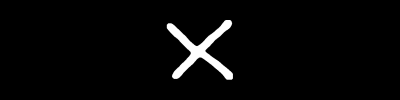

X_symbol


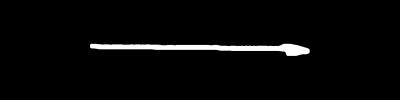

arrow_line


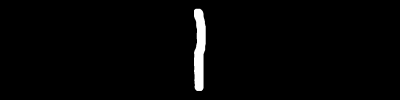

cutline


In [ ]:
for i in range(0,len(three_symbols)):
  cv2_imshow(three_symbols[i])
  print(classes[i])

## part 3. Digit Recognition model based on MNIST

### step 4.1 Load data from MNIST

In [ ]:
# load data and split them into train and test sets
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis = 1)
x_test = tf.keras.utils.normalize(x_test, axis = 1)

In [ ]:
# standardize input data
x_train = x_train.reshape([x_train.shape[0],28,28,1])
x_test = x_test.reshape([x_test.shape[0],28,28,1])
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# test
path_1 = '/content/drive/MyDrive/Project of Image Analysis/digit/test3-1.png'
path_5 = '/content/drive/MyDrive/Project of Image Analysis/digit/test3-5.png'
path_3 = '/content/drive/MyDrive/Project of Image Analysis/digit/test3-3.png'
path_3_2 = '/content/drive/MyDrive/Project of Image Analysis/digit/test6-3.jpg'

# X = np.array(empty,)
digit_1 = cv2.imread(path_1)[:,:,0]
digit_5 = cv2.imread(path_5)[:,:,0]
digit_3 = cv2.imread(path_3)[:,:,0]
digit_3_2 = cv2.imread(path_3_2)[:,:,0]
digit_1 = cv2.resize(digit_1, (28,28),interpolation = cv2.INTER_AREA).reshape(28,28,1)
digit_5 = cv2.resize(digit_5, (28,28),interpolation = cv2.INTER_AREA).reshape(28,28,1)
digit_3 = cv2.resize(digit_3, (28,28),interpolation = cv2.INTER_AREA).reshape(28,28,1)
digit_3_2 = cv2.resize(digit_3_2, (28,28),interpolation = cv2.INTER_AREA).reshape(28,28,1)
X = np.array([digit_1,digit_5,digit_3,digit_3_2])
y = np.array([1,5,3,3])
cv2_imshow(digit_5)
y

array([1, 5, 3, 3])

In [ ]:
# test
X_new = X[0][np.newaxis,:]
for i in range(1,len(X)):
  A = X[i][np.newaxis,:]
  X_new = np.vstack((X_new,A))

X_new.shape

(4, 28, 28, 1)

In [ ]:
digit_model.save('/content/drive/MyDrive/Project of Image Analysis/model/digit_1.h5')

In [ ]:
digit_model.fit(X_new,y,epochs = 500)

Epoch 1/500
1/1 [==============================] - 1s 666ms/step - loss: 1.8149 - accuracy: 0.7500
Epoch 2/500
1/1 [==============================] - 0s 48ms/step - loss: 0.8914 - accuracy: 0.7500
Epoch 3/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0492 - accuracy: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 43ms/step - loss: 0.1121 - accuracy: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 41ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 44ms/step - loss: 0.0286 - accuracy: 1.0000
Epoch 7/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 8/500
1/1 [==============================] - 0s 49ms/step - loss: 2.2741e-04 - accuracy: 1.0000
Epoch 9/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 10/500
1/1 [==============================] - 0s 43ms/step - loss: 4.3444e-04 - accuracy: 1.0000
Epoch 11/5

### step 4.2 Build the CNN model


In [ ]:
# building the cnn model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))

model.add(BatchNormalization(momentum = .05))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization(momentum=0.05))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization(momentum=.05))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

In [ ]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3

### step 4.3 Training model

In [ ]:
# training model
print('start training...')
model.fit(x_train,y_train,epochs = 5)
loss, accuracy = model.evaluate(x_test, y_test)

print(accuracy)
print(loss)

start training...
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4665 - accuracy: 0.8697
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1120 - accuracy: 0.9655
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0748 - accuracy: 0.9768
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0500 - accuracy: 0.9837
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0973 - accuracy: 0.9723
0.9722999930381775
0.09732991456985474


### step 4.4 Test the model, and evaluate it. 

In [ ]:
model.save('/content/drive/MyDrive/Project of Image Analysis/model/digit.h5')

## part 5. Classify the digit, one by one


### step 5.1 Detect digits symbol

In [ ]:
def extract_digits(digit_position,original_img):
  x,y,x2,y2 = digit_position
  digit_img = original_img[y:y2,x:x2]
  # cv2_imshow(digit_img)
  return digit_img

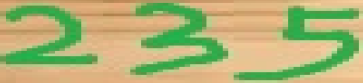

In [ ]:
digit_img = extract_digits(digit_position, t_image)
cv2_imshow(digit_img)

### step 5.2 Separate digits to single ones.

In [ ]:
model_path = '/content/drive/MyDrive/Project of Image Analysis/model/digit_1.h5'
digit_model = models.load_model(model_path)


In [ ]:
#the output is each number within a black box
def preprocess_digits(img):
  def resize(img):
    width, height = 28, 28
    resized = cv2.resize(img, (width,height),interpolation = cv2.INTER_AREA)
    # image = resized.reshape(height, width, 1)
    # img = np.invert(np.array([resized]))
    img = resized.reshape(28,28,1)
    return img
    
  grayy = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(grayy)
  #grayscale and tresholding
  ret, mask = cv2.threshold(grayy, 125, 255, cv2.THRESH_BINARY)
  # ret, mask = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  # cv2_imshow(mask_inv)

  #add bounding boxes
  # Draw rectangle and save each ROI and add border
  cnts = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
 
  value = (200, 200, 200)
  x_position = []
  digits = []
  # for c in sorted_ctrs:
  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      x_position.append(x)
      img = cv2.rectangle(grayy, (x, y), (x + w, y + h), (255,255,255), 2)
      ROI = grayy[y:y+h, x:x+w]
      # cv2_imshow(ROI)
 
      ret, mask = cv2.threshold(ROI, 140, 255, cv2.THRESH_BINARY)
      mask_inv = cv2.bitwise_not(mask)
      border_image = cv2.copyMakeBorder(mask_inv, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value)

      digits.append(resize(border_image))
  # sort the digits from left to right
  for i in range(len(x_position)):
    for j in range(len(x_position) - i - 1):
      if x_position[j] > x_position[j+1]:
        x_position[j], x_position[j+1] = x_position[j+1], x_position[j]
        digits[j], digits[j+1] = digits[j+1], digits[j]
  
  return digits


In [ ]:
# test
temp = preprocess_digits(digit_img)
# cv2_imshow(temp)
# temp.shape
for i in range(len(temp)):
  cv2_imshow(temp[i])

### step 5.3 Taking usage of the pre trained model to classify the digits that will get a list of single numbers.

In [ ]:
# standardize the single digit

#the output is each number within a black box
def preprocess_digit(img):
  # set the size as 28,28

  def standard_background(image):
    height, width = image.shape[:2]
    length = max(height, width)

    black = np.zeros((length,length,1), dtype = "uint8")
    x = int((length - width)/2)
    y = int((length - height)/2)
    x2 = int((length + width)/2)
    y2 = int((length + height)/2)
    image = image.reshape(height,width,1)
    black[y:y2, x:x2] = image
    img = resize(black)
    return img

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #HSV
  lower_black = np.array([0,0,0])
  upper_black = np.array([150,170,150])
  
  # Threshold the HSV image to get only blue colors
  mask = cv2.inRange(hsv, lower_black, upper_black)

  # Bitwise-AND mask and original image
  res = cv2.bitwise_and(img,img, mask= mask)
  
  #tresholding
  kernel = np.ones((5,5),np.uint8)
  gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

  ret,thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
  dilation = cv2.dilate(thresh1,kernel,iterations = 1)
  image = standard_background(dilation)

  # return dilation
  return image


def digit_recognition(img):
  img = preprocess_digits(img) # split digits to single ones
  # img = input_standardization(img)
  digits = []
  for digit in img:
    digit = np.invert(np.array([digit]))
    prediction = digit_model.predict(digit)
    # print(f'prediction result: {np.argmax(prediction)}')
    print(f'prediction result: {np.argmax(prediction)}')
    plt.imshow(digit.reshape(28,28),cmap = plt.cm.binary)
    # plt.imshow(img[0])
    plt.show()
    digit_pred = np.argmax(prediction)
    digits.append(digit_pred)
    # calculate the value of digits
    digits_value = 0
    n = len(digits)
    for i in range(n):
      digits_value += digits[i]*(10**(n-i-1))
  return digits_value


prediction result: 2


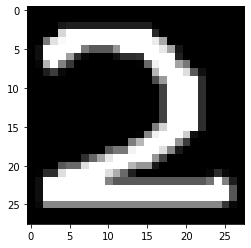

prediction result: 3


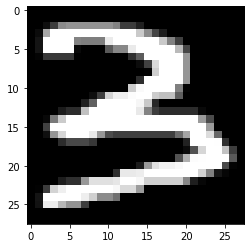

prediction result: 5


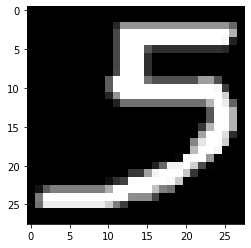

In [ ]:
digits_value = digit_recognition(digit_img)

In [ ]:
digits_value

235

## output image

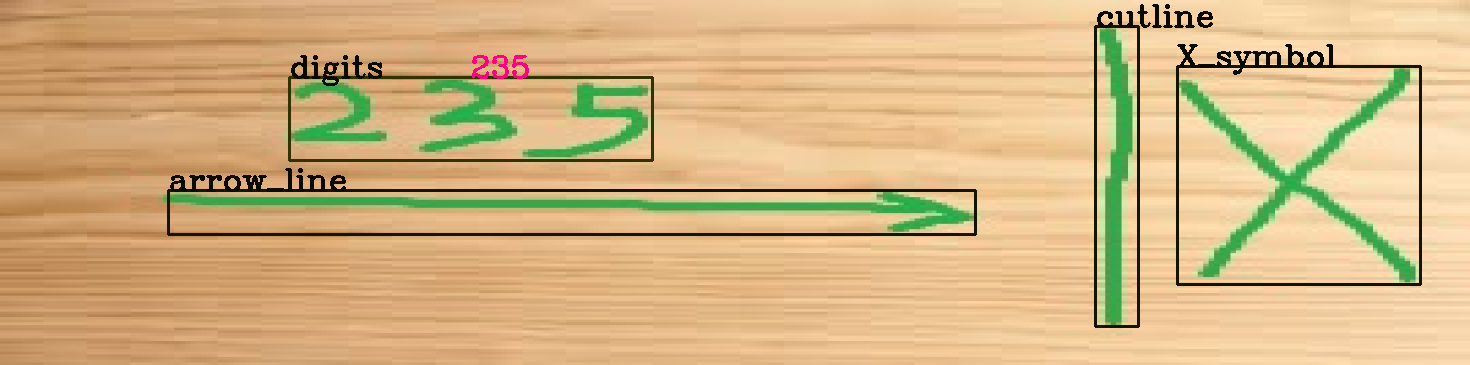

In [ ]:
# t_image = cv2.resize(test_image, (1470,365),interpolation = cv2.INTER_AREA)
for i in range(4):
  if i == 3:
    x,y,x2,y2 = digit_position
    cv2.rectangle(t_image,(x,y),(x2,y2),(0,50,50),2)
    cv2.putText(t_image,classes[i],(x,y),cv2.FONT_HERSHEY_COMPLEX,1,(0,10,10),2)
    cv2.putText(t_image,str(digits_value),(int((x+x2)/2),y),cv2.FONT_HERSHEY_COMPLEX,1,(130,0,255),2)
  else:
    x,y,w,h = symbol_positions[i]
    cv2.rectangle(t_image,(x,y),(x+w,y+h),(0,20,20),2)
    cv2.putText(t_image,classes[i],(x,y),cv2.FONT_HERSHEY_COMPLEX,1,(0,10,10),2)
cv2_imshow(t_image)